In [ ]:
# use Neurogen Model to predict brain response

In [1]:
import sys
import os
import struct
import time as time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader,Dataset
import argparse
import pandas as pd
from visualize import center_crop

from torch_fwrf import learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block
from encoding import load_encoding

In [1]:
#paths

nsd_root = 'Z:/CNAI2/Mansoure_NSD/'
stim_root = nsd_root + "nsd_stimuli/"
beta_root = nsd_root + "nsd_beta/"
#mask_root = nsd_root + "mask/ppdata/"
#roi_root = nsd_root + "freesurfer/"
meanROIbeta_root = nsd_root + "roiavgbeta/"
output_root = nsd_root + "phase2/output/"

exp_design_file = nsd_root + "experiments/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"


In [49]:
# parameters
subject = 8
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
model_name = 'dnn_fwrf'

# number of trials for all subjects
trials = np.array([30000, 30000, 24000, 22500, 30000, 24000, 30000, 22500])

In [50]:
# load behavior data

exp_design = loadmat(exp_design_file)
# order of image id in trials
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print('ordering shape', ordering.shape)
# image id for each subject
subject_idx  = exp_design['subjectim']
print('subject_idx shape', subject_idx.shape)
# shared image id
shared_idx   = exp_design['sharedix']


ordering shape (30000,)
subject_idx shape (8, 10000)


In [51]:
# load center cropped images
image_data_set = h5py.File(stim_root + f'S{subject:d}_stimuli_227.h5py', 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data_set.close()

print ('image data shape', image_data.shape)
#print (image_data.dtype)
#print (np.min(image_data[0]), np.max(image_data[0]))


image data shape (10000, 3, 227, 227)


In [52]:
# choose the 1000 shared images

data_size = trials[subject-1]
ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices
test_size = np.sum(shared_mask)
print('test size', test_size)

test_image_data = image_data[:1000]
print('test_image_data shape', test_image_data.shape)

test size 2188
test_image_data shape (1000, 3, 227, 227)


In [53]:
# load beta

ROIs = ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
#ROIs = ['L_hippocampus', 'L_amygdala', 'R_hippocampus', 'R_amygdala']
roi_num = len(ROIs)
roi_data = np.zeros([data_size, roi_num])
n = 0
del_idx = []
for roi in ROIs:
    roi_data[:,n] = np.genfromtxt(meanROIbeta_root + f'subj{subject:02d}/meanbeta_' + roi + '.txt')
    if np.isnan(np.sum(roi_data[:,n])):
    	del_idx.append(n)
    n += 1

roi_data = np.delete(roi_data, del_idx, axis=1)
test_roi_data = roi_data[shared_mask]

print('test beta shape', test_roi_data.shape)


test beta shape (2188, 24)


In [54]:
# load encoding models
fwrf, fmaps = load_encoding(subject, model_name='dnn_fwrf')

# load params
model_params_set = h5py.File(output_root+f'subj{subject:02d}/model_params.h5py' , 'r')
model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
model_params_set.close()

In [55]:
# predict brain response
voxel_pred = get_predictions(test_image_data, fmaps, fwrf, model_params['params'])


samples [  900:999  ] of 1000, voxels [     0:23    ] of 24
---------------------------------------
total time = 3.530641s
sample throughput = 0.003531s/sample
voxel throughput = 0.147110s/voxel


test pred shape (2188, 24)


100%|██████████| 24/24 [00:00<00:00, 9602.53it/s]


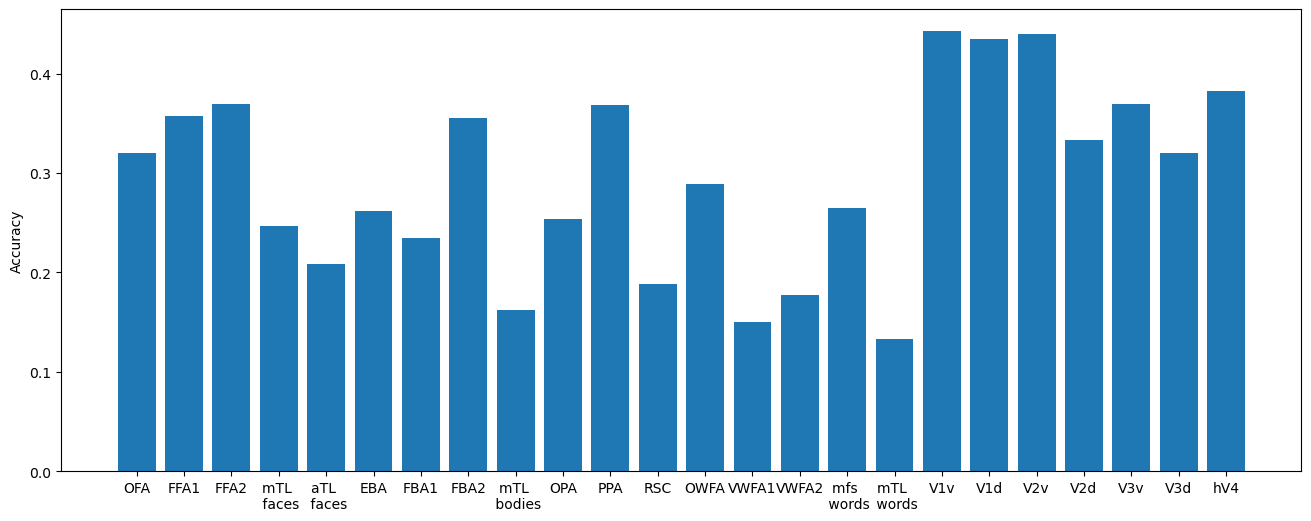

In [56]:
# correlate predicted response and beta

test_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
print('test pred shape', test_voxel_pred.shape)
accuracy  = np.zeros(shape=(test_voxel_pred.shape[1]))

for v in tqdm(range(test_voxel_pred.shape[1])):    
    accuracy[v] = np.corrcoef(test_roi_data[:,v], test_voxel_pred[:,v])[0,1]  
    

accuracy = np.nan_to_num(accuracy)

# plot the accuracy for all rois
ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
ROIs_label = np.delete(ROIs_label,del_idx) 

plt.figure(figsize=(16,6))
plt.bar(ROIs_label,accuracy)
plt.ylabel('Accuracy')

save_dir = nsd_root + f'output/subj{subject:02d}/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.savefig(save_dir + 'Accuracy.png')


In [57]:
# save predictions

# ROIs_num = np.array(range(24))
# ROIs_num = np.delete(ROIs_num,del_idx)

# pred_act = np.concatenate((voxel_pred,ROIs_num.reshape([len(ROIs_num),1]).T), axis=0)

# print('activation and roi id shape', pred_act.shape)

ROIs_bool = np.ones((24,1), dtype = 'bool')
ROIs_bool[del_idx] = False

pred_act = np.zeros((1000,24))
pred_act[:,ROIs_bool[:,0]] = voxel_pred

with open(save_dir + 'act_pred.npy', 'wb') as f:
    np.save(f, pred_act)

save_acc = np.zeros([1,24])
save_acc[:,ROIs_bool[:,0]] = accuracy

with open(save_dir + 'acc.npy', 'wb') as f:
    np.save(f, save_acc)